# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 06, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


In [2]:
from os.path import join
import numpy as np


from SciDataTool.Functions.Plot.plot_2D import plot_2D
from SciDataTool.Functions.Plot.plot_3D import plot_3D
from pyleecan.Functions.Plot import dict_2D, dict_3D

from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.PostLUT import PostLUT
from pyleecan.Classes.Electrical import Electrical
from pyleecan.Classes.EEC_PMSM import EEC_PMSM
from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D
from pyleecan.Functions.Electrical.dqh_transformation import (
    get_phase_dir_DataTime,
    n2dqh_DataTime,
)
from pyleecan.definitions import DATA_DIR
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT



# ELUT 생성

In [ ]:
n_Id=5
n_Iq=5
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Generate ELUT
name = "tuto_EEC_ELUT_PMSM"
simu = Simu1(name=name, machine=Toyota_Prius)

# Definition of the input
simu.input = InputCurrent(
Nt_tot=8 * 12*8, #96*8
Na_tot=8 * 200, #1600
OP=OPdq(N0=1000, Id_ref=0, Iq_ref=0),
)

# Build OP_matrix with a meshgrid of Id/Iq
Id_min, Id_max = -200, 200
Iq_min, Iq_max = -200, 200
Id, Iq = np.meshgrid(
np.linspace(Id_min, Id_max, n_Id), np.linspace(Iq_min, Iq_max, n_Iq)
)

In [4]:
OP_matrix = np.zeros((n_Id * n_Iq, 3))
OP_matrix[:, 0] = simu.input.OP.N0
OP_matrix[:, 1] = Id.ravel() #ravel() 다차원 배열 1차원 변환 함수
OP_matrix[:, 2] = Iq.ravel()

In [6]:
# Set varspeed simulation
simu.var_simu = VarLoadCurrent(
type_OP_matrix=1,
OP_matrix=OP_matrix,
is_keep_all_output=True,
stop_if_error=True,
)
# simu for FEMM comparison
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=16)
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True,is_agsf_transfer=True,max_wavenumber_transfer=96)

simu.var_simu.postproc_list = [PostLUT(is_save_LUT=True)]

out = simu.run()

ELUT = out.simu.var_simu.postproc_list[0].LUT


[17:47:45] Starting running simulation tuto_EEC_ELUT_PMSM (machine=Toyota_Prius)
[17:47:45] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[17:47:45] Computing reference simulation for Variable Load
[17:47:45] Starting Magnetic module
[17:47:46] Parallelization is set on 16 threads while your computer only has 12.
[17:47:46] Solving time step 7 / 96 in FEMM
[17:47:46] Solving time step 13 / 96 in FEMM
[17:47:47] Solving time step 19 / 96 in FEMM
[17:47:47] Solving time step 31 / 96 in FEMM
[17:47:47] Solving time step 25 / 96 in FEMM
[17:47:48] Solving time step 43 / 96 in FEMM
[17:47:48] Solving time step 37 / 96 in FEMM
[17:47:48] Solving time step 8 / 96 in FEMM
[17:47:49] Solving time step 14 / 96 in FEMM
[17:47:49] Solving time step 1 / 96 in FEMM
[17:47:50] Solving time step 9 / 96 in FEMM
[17:47:50] Solving time step 32 / 96 in FEMM
[17:47:50] Solving time step 20 / 96 in FEMM
[17:47:50] Solving time step 61 / 96 in FEMM
[17:47:50] Solving t

<class 'list'>
12


c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


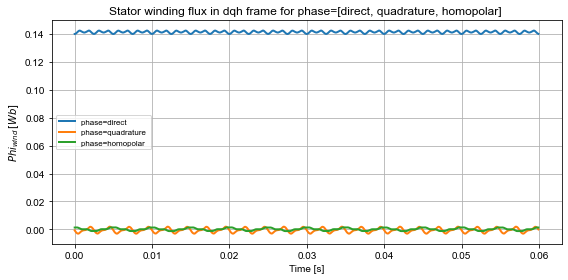

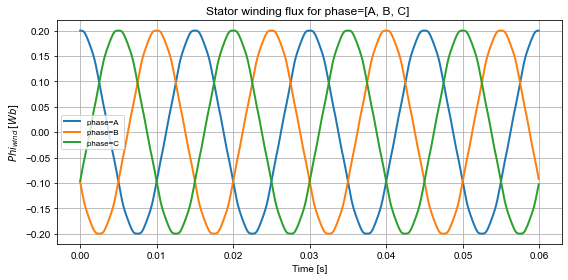

In [7]:
OP_list = OP_matrix[:, 1:3].tolist() # tolist list형태로 변환하는 method

ELUT = out.simu.var_simu.postproc_list[0].LUT
#ELUT1=out.simu.var_simu.postproc_list[1].LUT
Phi_dqh_mean = ELUT.get_Phidqh_mean()
Phi_dqh_mean.size
ii = OP_list.index([0, 0])  #[0,0 ]이 있는 위치 반환
print(type(OP_list))
print(ii)


# 무부하에서의 Phi_dqh0
Phi_dqh0 = n2dqh_DataTime(
    ELUT.Phi_wind[ii],
    is_dqh_rms=True,
    phase_dir=ELUT.get_phase_dir(),
)

Phi_dqh0_mean = Phi_dqh0.get_along("time=mean", "phase")[Phi_dqh0.symbol]

Phi_dqh0 = n2dqh_DataTime(
    ELUT.Phi_wind[ii],
    is_dqh_rms=True,
    phase_dir=ELUT.get_phase_dir(),
)


Phi_dqh0.plot_2D_Data(
"time",
"phase[]"
)

# ELUT.Phi_wind[1].plot_2D_Data(
# "time",
# "phase[]"
# )
ELUT.Phi_wind[ii].plot_2D_Data(
"time",
"phase[]"
)


c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


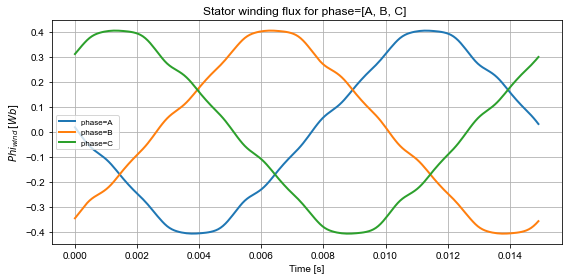

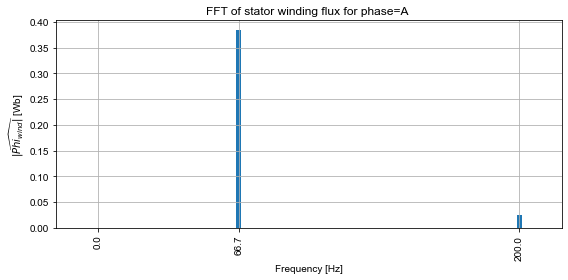

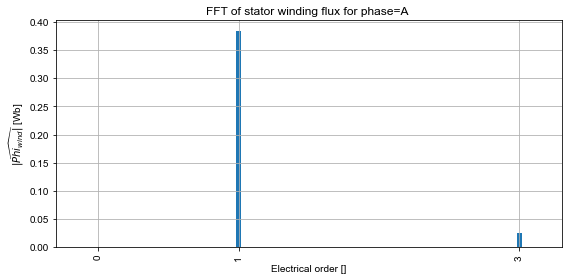

In [8]:
# type(ii)
# ELUT.Phi_wind[1]=ELUT.Phi_wind[1].time_to_freq()
ELUT.Phi_wind[1].plot_2D_Data(
"time[oneperiod]",
"phase[]"
)
ELUT.Phi_wind[1].plot_2D_Data("freqs")
ELUT.Phi_wind[1].plot_2D_Data("freqs->elec_order=[0,8]")

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

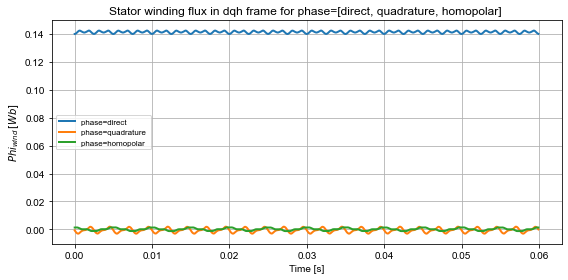

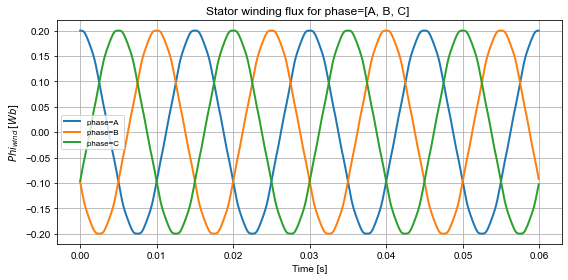

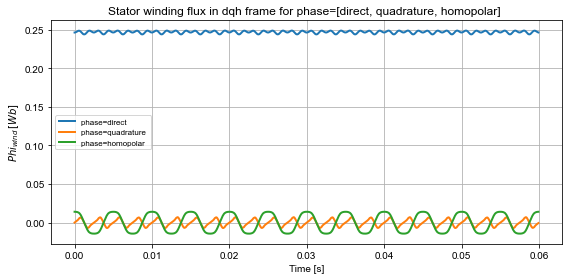

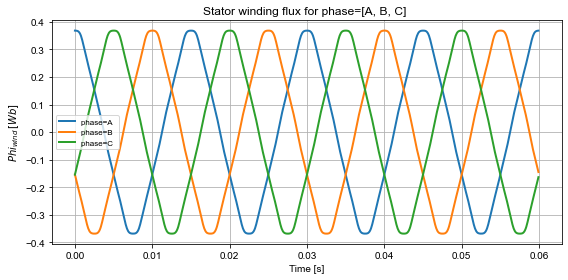

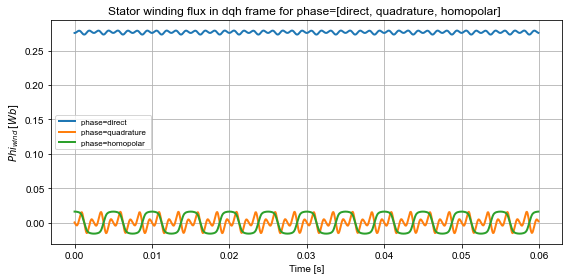

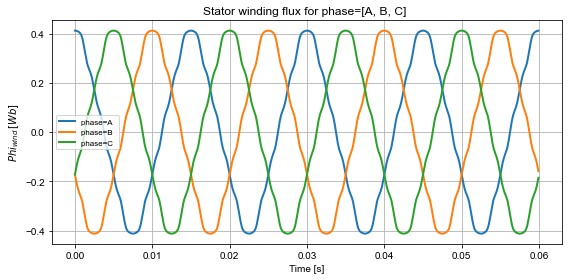

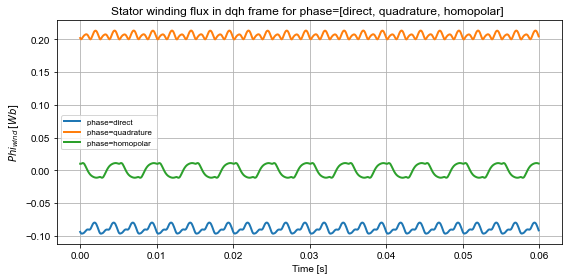

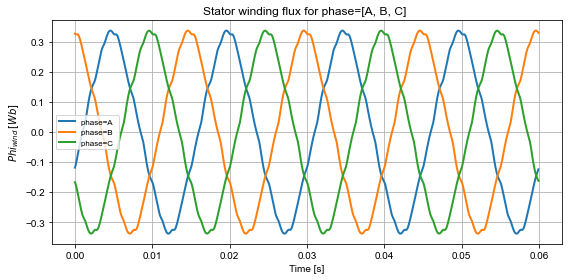

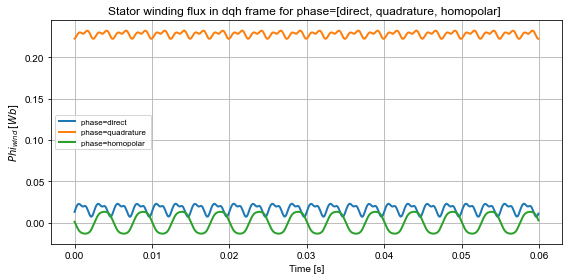

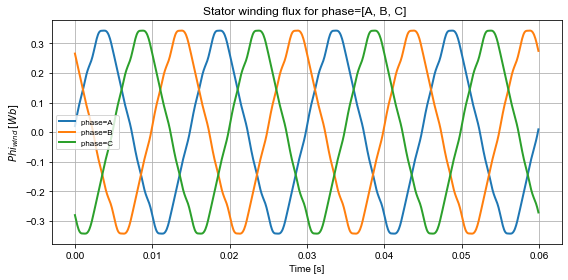

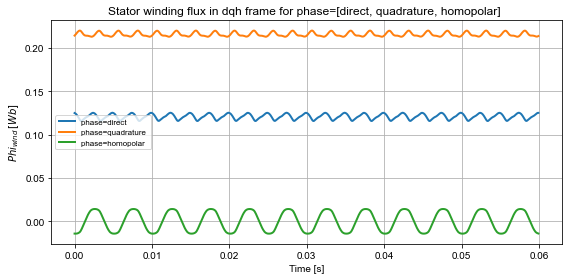

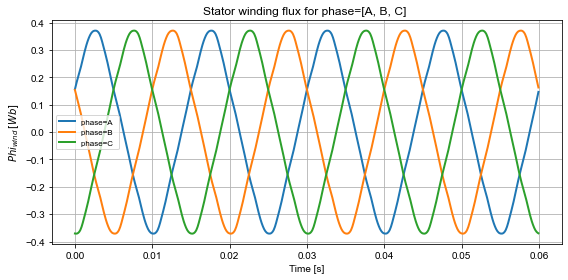

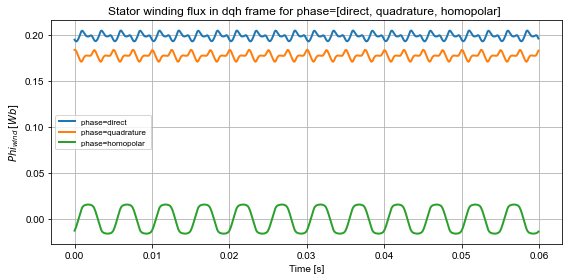

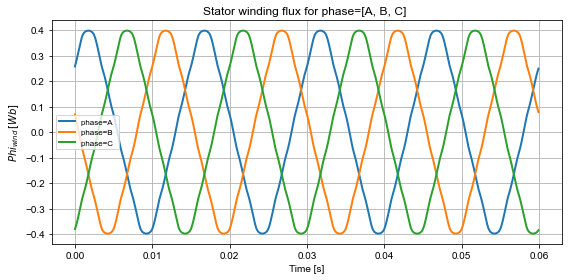

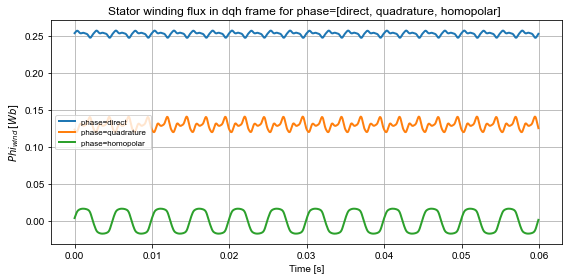

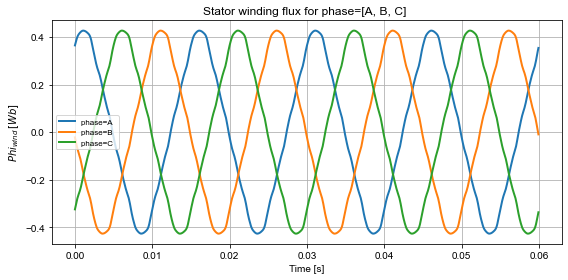

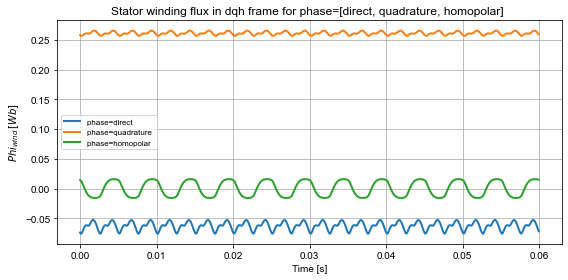

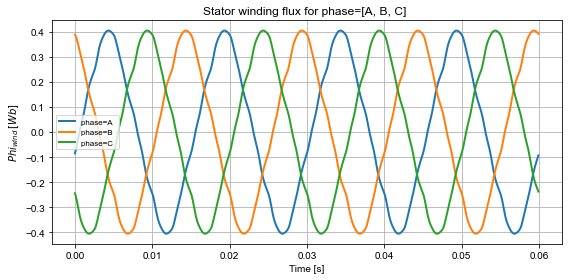

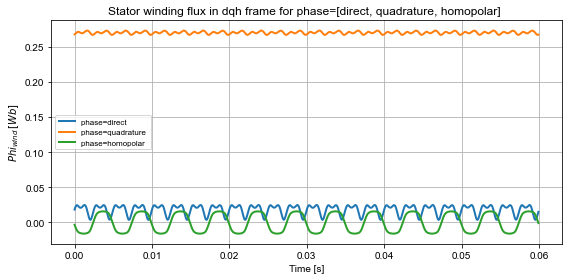

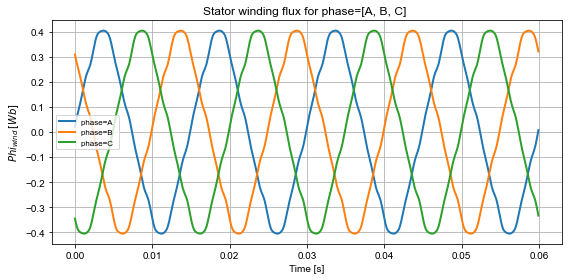

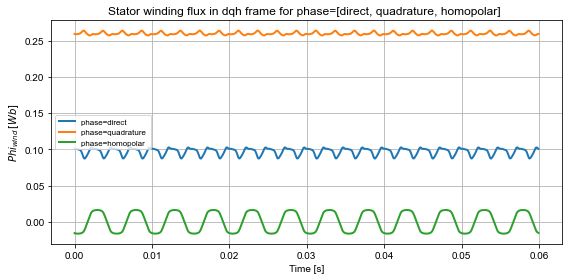

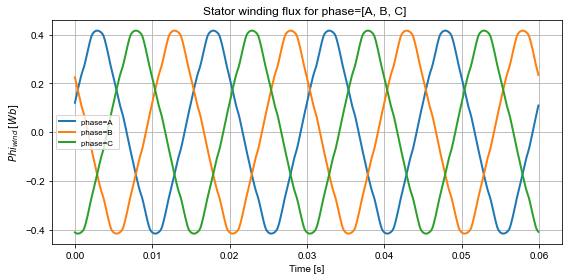

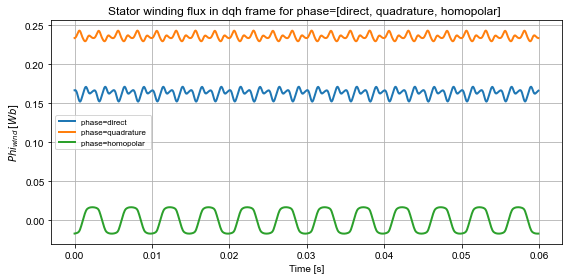

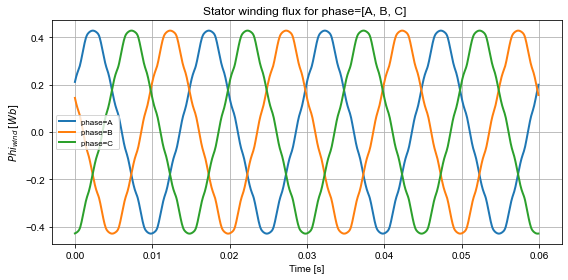

In [9]:
# Phi_dqh0.plot_2D_Data("time")
for ii in range(12, 24):
    Phi_dqh0 = n2dqh_DataTime(
        ELUT.Phi_wind[ii],
        is_dqh_rms=True,
        phase_dir=ELUT.get_phase_dir(),
    )


    Phi_dqh0.plot_2D_Data(
    "time",
    "phase[]"
    )

    # ELUT.Phi_wind[1].plot_2D_Data(
    # "time",
    # "phase[]"
    # )
    ELUT.Phi_wind[ii].plot_2D_Data(
    "time",
    "phase[]"
    )

## Plot - dq평면 토크contour, 전압원

In [28]:
import matplotlib.pyplot as plt
elec_model = Electrical(eec=EEC_PMSM(), Tsta=Tsta, Tmag=20, Trot=20)


# Init plot map
dict_map = {
    "Xdata": Id.reshape((n_Iq, n_Id))[0, :],
    "Ydata": Iq.reshape((n_Iq, n_Id))[:, 0],
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolor",
    "is_contour": True,
     "is_show_fig": True,
}
# # Plot torque maps
plot_3D(
    Zdata=Tem_interp.reshape((n_Iq, n_Id)).T,
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
   #save_path=join(save_path, name + "_torque_map.png"),
    **dict_map,
)
# plot 전압원 

# plt.contour(
#     dict_map["Xdata"],
#     dict_map["Ydata"],
#     U_max_interp.reshape((n_Iq, n_Id)),
#     colors="blue",
#     linewidths=0.8,
# )
plot_3D(
    Zdata=Id.reshape((n_Iq, n_Id)).T,
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
    # save_path=join(save_path, name + "_torque_map.png"),
    **dict_map,
)
plot_3D(
    Zdata=Iq.reshape((n_Iq, n_Id)).T,
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
    # save_path=join(save_path, name + "_torque_map.png"),
    **dict_map,
)



NameError: name 'Tem_interp' is not defined

## 자속맵 (dq평면)

In [27]:
elec_model = Electrical(eec=EEC_PMSM(), Tsta=Tsta, Tmag=20, Trot=20)


# Plot Phi_d map
plot_3D(
    Zdata=elec_model.eec.parameters["Phid"].reshape((n_Iq, n_Id)).T,
    zlabel="$\Phi_d$ [Wb]",
    title="Flux linkage map in dq plane (d-axis)",
    #save_path=join(save_path, name + "_phid_map.png"),
    **dict_map,
)

# Plot Phi_q map
plot_3D(
    Zdata=elec_model.eec.parameters["Phiq"].reshape((n_Iq, n_Id)).T,
    zlabel="$\Phi_q$ [Wb]",
    title="Flux linkage map in dq plane (q-axis)",
    #save_path=join(save_path, name + "_phiq_map.png"),
    **dict_map,
)

# plot_3D(
#     Zdata=Tem_sync.reshape((n_Iq, n_Id)).T,
#     zlabel="Synchrnous Torque [N.m]",
#     title="Torque map in dq plane",
#     #save_path=join(save_path, name + "_torque_sync_map.png"),
#     **dict_map,
# )
# plot_3D(
#     Zdata=Tem_rel.reshape((n_Iq, n_Id)).T,
#     zlabel="Reluctant Torque [N.m]",
#     title="Torque map in dq plane",
#     #save_path=join(save_path, name + "_torque_rel_map.png"),
#     **dict_map,
# )

KeyError: 'Phid'

## MTPA 

In [ ]:
ELUT = out.simu.var_simu.postproc_list[0].LUT
test_ELUT=ELUT

In [22]:
"""Validation of the PMSM Electrical Equivalent Circuit with the Prius machine for MTPA calculation"""

n_Id=51
n_Iq=101
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
qs = Toyota_Prius.stator.winding.qs
p = Toyota_Prius.get_pole_pair_number()
Tsta = 20  # stator winding temperature

In [24]:
name = "test_EEC_ELUT_PMSM_MTPA"
simu_MTPA = Simu1(name=name, machine=Toyota_Prius)

# Definition of the input
OP_ref = OPdq(N0=1000, Id_ref=50, Iq_ref=100)
simu_MTPA.input = InputCurrent(
    Na_tot=1024,
    Nt_tot=1024,
    OP=OP_ref,
)

OP_matrix = ELUT.OP_matrix

# Get Id_min, Id_max, Iq_min, Iq_max from OP_matrix
Id_min = np.min(OP_matrix[:, 1])
Id_max = np.max(OP_matrix[:, 1])
Iq_min = np.min(OP_matrix[:, 2])
Iq_max = np.max(OP_matrix[:, 2])

Id, Iq = np.meshgrid(
    np.linspace(Id_min, Id_max, n_Id), np.linspace(Iq_min, Iq_max, n_Iq)
)

Id, Iq = Id.ravel(), Iq.ravel()  #ravel()_numpy 다차원 배열을 1차원 변환
Imax_interp = np.sqrt(Id ** 2 + Iq ** 2)
OP_matrix

array([[1000., -200., -200.,   nan,   nan],
       [1000., -100., -200.,   nan,   nan],
       [1000.,    0., -200.,   nan,   nan],
       [1000.,  100., -200.,   nan,   nan],
       [1000.,  200., -200.,   nan,   nan],
       [1000., -200., -100.,   nan,   nan],
       [1000., -100., -100.,   nan,   nan],
       [1000.,    0., -100.,   nan,   nan],
       [1000.,  100., -100.,   nan,   nan],
       [1000.,  200., -100.,   nan,   nan],
       [1000., -200.,    0.,   nan,   nan],
       [1000., -100.,    0.,   nan,   nan],
       [1000.,    0.,    0.,   nan,   nan],
       [1000.,  100.,    0.,   nan,   nan],
       [1000.,  200.,    0.,   nan,   nan],
       [1000., -200.,  100.,   nan,   nan],
       [1000., -100.,  100.,   nan,   nan],
       [1000.,    0.,  100.,   nan,   nan],
       [1000.,  100.,  100.,   nan,   nan],
       [1000.,  200.,  100.,   nan,   nan],
       [1000., -200.,  200.,   nan,   nan],
       [1000., -100.,  200.,   nan,   nan],
       [1000.,    0.,  200.,   n

In [25]:
# Electrical 모듈 

# elec_model = Electrical(eec=EEC_PMSM(LUT_enforced=test_ELUT), Tsta=Tsta, Tmag=20, Trot=20)
# elec_model_2 =Electrical(eec=EEC_PMSM(LUT_enforced=test_ELUT), Tsta=Tsta, Tmag=20, Trot=20)
elec_model = Electrical(eec=EEC_PMSM(), Tsta=Tsta, Tmag=20, Trot=20)
# Interpolate stator winding flux in dqh frame for all Id/Iq
# elec_model.eec.comp_parameters(
#     machine=Toyota_Prius, OP=OP_ref, Tsta=elec_model.Tsta, Id_array=Id, Iq_array=Iq
# )

elec_model.eec.comp_parameters(
    machine=Toyota_Prius, OP=OP_ref, Tsta=Tsta,is_comp_ind=False)

# #아직 stator권선의 온도영향도만 반영되어있음
# elec_model_2.eec.comp_parameters(
#     machine=Toyota_Prius, OP=OP_ref, Tsta=elec_model.Tsta, Trot=elec_model_2, Id_array=Id, Iq_array=Iq
# )

# Compute torque
Tem_sync, Tem_rel = elec_model.eec.comp_torque_sync_rel(qs, p)
Tem_interp = Tem_sync + Tem_rel

Tem_sync2, Tem_rel2 = elec_model_2.eec.comp_torque_sync_rel(qs, p)
Tem_interp2 = Tem_sync2 + Tem_rel2

TypeError: comp_parameters() got an unexpected keyword argument 'is_comp_ind'

## MTPA 계산을 통한 TN curve 작성 

In [26]:


# Maximum current [Arms]
I_max = 250 / np.sqrt(2)
# Maximum voltage [Vrms]
U_max = 400
# Speed vector
Nspeed = 50
N0_min = 50
N0_max = 8000
N0_vect = np.linspace(N0_min, N0_max, Nspeed)
# Maximum load vector
Ntorque = 1
is_braking = False  # True to include negative torque (braking)

if is_braking:
    Ntorque = (
        2 * Ntorque + 1
    )  # Take twice the number of torques + odd to include zero torque
if not is_braking and Ntorque == 1:
    I_max_vect = np.array([I_max])
elif is_braking:
    I_max_vect = np.linspace(-I_max, I_max, Ntorque)
else:
    I_max_vect = np.linspace(0, I_max, Ntorque)

# Init OP_matrix
OP_matrix_MTPA = np.zeros((Nspeed, Ntorque, 4))
U_MTPA = np.zeros((Nspeed, Ntorque, 3))
I_MTPA = np.zeros((Nspeed, Ntorque, 3))

for ii, N0 in enumerate(N0_vect):

    print("Speed " + str(ii + 1) + "/" + str(Nspeed))

    # Update operating point
    OP_ref.N0 = N0
    OP_ref.felec = None

    # Update stator resistance with skin effect
    elec_model.eec.comp_parameters(
        Toyota_Prius,
        OP=OP_ref,
        Tsta=elec_model.Tsta,
        Trot=elec_model.Trot,
    )

    # Calculate voltage
    out_dict = elec_model.eec.solve()
    U_max_interp = np.sqrt(out_dict["Ud"] ** 2 + out_dict["Uq"] ** 2)
    
# ii는 속도의 인덱스
## kk는 토크 인덱스
# j0는 현재 index
# jmax는 MTPA 토크

    for kk, I_max0 in enumerate(I_max_vect):

        if I_max0 == 0:
            # Finding indices of operating points satisfying Vmax voltage for Iq=0 (no torque production)
            j0 = np.logical_and(U_max_interp <= U_max, np.abs(Iq) == 0)

            # Finding index of operating point giving lowest current
            jmax = np.argmin(np.abs(Imax_interp[j0]))

        else:
            # Finding indices of operating points satisfying Vmax and XImax(i) voltage and torque limitations
            j0 = np.logical_and(
                U_max_interp <= U_max, Imax_interp <= np.abs(I_max0)
            )

            if I_max0 > 0:
                # Finding index of operating point giving maximum positive torque among feasible operating points
                jmax = np.argmax(Tem_interp[j0])
            else:
                # Finding index of operating point giving maximum negative torque among feasible operating points
                jmax = np.argmin(Tem_interp[j0])

        # Store values in MTPA
        OP_matrix_MTPA[ii, kk, 0] = N0
        OP_matrix_MTPA[ii, kk, 1] = Id[j0][jmax]
        OP_matrix_MTPA[ii, kk, 2] = Iq[j0][jmax]
        OP_matrix_MTPA[ii, kk, 3] = Tem_interp[j0][jmax]
        U_MTPA[ii, kk, 0] = out_dict["Ud"][j0][jmax]
        U_MTPA[ii, kk, 1] = out_dict["Uq"][j0][jmax]
        U_MTPA[ii, kk, 2] = U_max_interp[j0][jmax]
        I_MTPA[ii, kk, 0] = OP_matrix_MTPA[ii, kk, 1]
        I_MTPA[ii, kk, 1] = OP_matrix_MTPA[ii, kk, 2]
        I_MTPA[ii, kk, 2] = Imax_interp[j0][jmax]

if Ntorque == 1:
    # Plot torque speed curve for each load level
    y_list = list()
    legend_list = list()
    for i_load in range(Ntorque):
        y_list.append(OP_matrix_MTPA[:, i_load, 3])
        #legend_list.append(
        #    "Load level = " + str(int(round(100 * (i_load) / (Ntorque - 1)))) + " %"
        #)
    plot_2D(
        [OP_matrix_MTPA[:, i_load, 0]],
        y_list,
        xlabel="Speed [rpm]",
        ylabel="Average torque [N.m]",
        legend_list=legend_list,
#         save_path=join(save_path, name + "_MTPA_torque_speed.png"),
#         is_show_fig=is_show_fig,
    )
if Ntorque > 1:
    # Plot torque speed curve for each load level
    y_list = list()
    legend_list = list()
    for i_load in range(Ntorque):
        y_list.append(OP_matrix_MTPA[:, i_load, 3])
        #legend_list.append(
        #    "Load level = " + str(int(round(100 * (i_load) / (Ntorque - 1)))) + " %"
        #)
    plot_2D(
        [OP_matrix_MTPA[:, i_load, 0]],
        y_list,
        xlabel="Speed [rpm]",
        ylabel="Average torque [N.m]",
        legend_list=legend_list,
#         save_path=join(save_path, name + "_MTPA_torque_speed.png"),
#         is_show_fig=is_show_fig,
    )


i_load = -1

plot_2D(
    [OP_matrix_MTPA[:, i_load, 0]],
    [I_MTPA[:, i_load, 0], I_MTPA[:, i_load, 1], I_MTPA[:, i_load, 2]],
    xlabel="Speed [rpm]",
    ylabel="Current [Arms]",
    legend_list=["Id", "Iq", "Imax"],
#     save_path=join(save_path, name + "_current_MTPA_OP" + str(i_load) + ".png"),
#     is_show_fig=is_show_fig,
)

plot_2D(
    [OP_matrix_MTPA[:, i_load, 0]],
    [U_MTPA[:, i_load, 0], U_MTPA[:, i_load, 1], U_MTPA[:, i_load, 2]],
    xlabel="Speed [rpm]",
    ylabel="Voltage [Vrms]",
    legend_list=["Ud", "Uq", "Umax"],
#     save_path=join(save_path, name + "_voltage_MTPA_OP" + str(i_load) + ".png"),
#     is_show_fig=is_show_fig,
)



Speed 1/50


AttributeError: 'NoneType' object has no attribute 'comp_inductance'